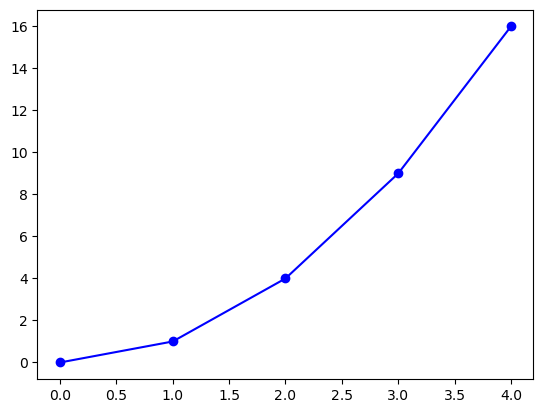

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors

x = [0, 1, 2, 3, 4]
y = [0, 1, 4, 9, 16]
plt.plot(x, y, marker='o', linestyle='-', color='b')

Generating synthetic dataset...
Generated 10/100 images
Generated 20/100 images
Generated 30/100 images
Generated 40/100 images
Generated 50/100 images
Generated 60/100 images
Generated 70/100 images
Generated 80/100 images
Generated 90/100 images
Generated 100/100 images
Training model...
Using device: cuda
Epoch 1/20, Batch 0/20, Loss: 1.1638
Epoch 1/20, Batch 10/20, Loss: 0.4620
Epoch 1/20, Train Loss: 0.5368, Val Loss: 0.2920, Pixel Accuracy: 0.9494
Epoch 2/20, Batch 0/20, Loss: 0.2981
Epoch 2/20, Batch 10/20, Loss: 0.2217
Epoch 2/20, Train Loss: 0.2286, Val Loss: 0.1666, Pixel Accuracy: 0.9510
Epoch 3/20, Batch 0/20, Loss: 0.1704
Epoch 3/20, Batch 10/20, Loss: 0.1362
Epoch 3/20, Train Loss: 0.1445, Val Loss: 0.1293, Pixel Accuracy: 0.9659
Epoch 4/20, Batch 0/20, Loss: 0.1267
Epoch 4/20, Batch 10/20, Loss: 0.1082
Epoch 4/20, Train Loss: 0.1074, Val Loss: 0.0998, Pixel Accuracy: 0.9699
Epoch 5/20, Batch 0/20, Loss: 0.0840
Epoch 5/20, Batch 10/20, Loss: 0.0731
Epoch 5/20, Train Loss:

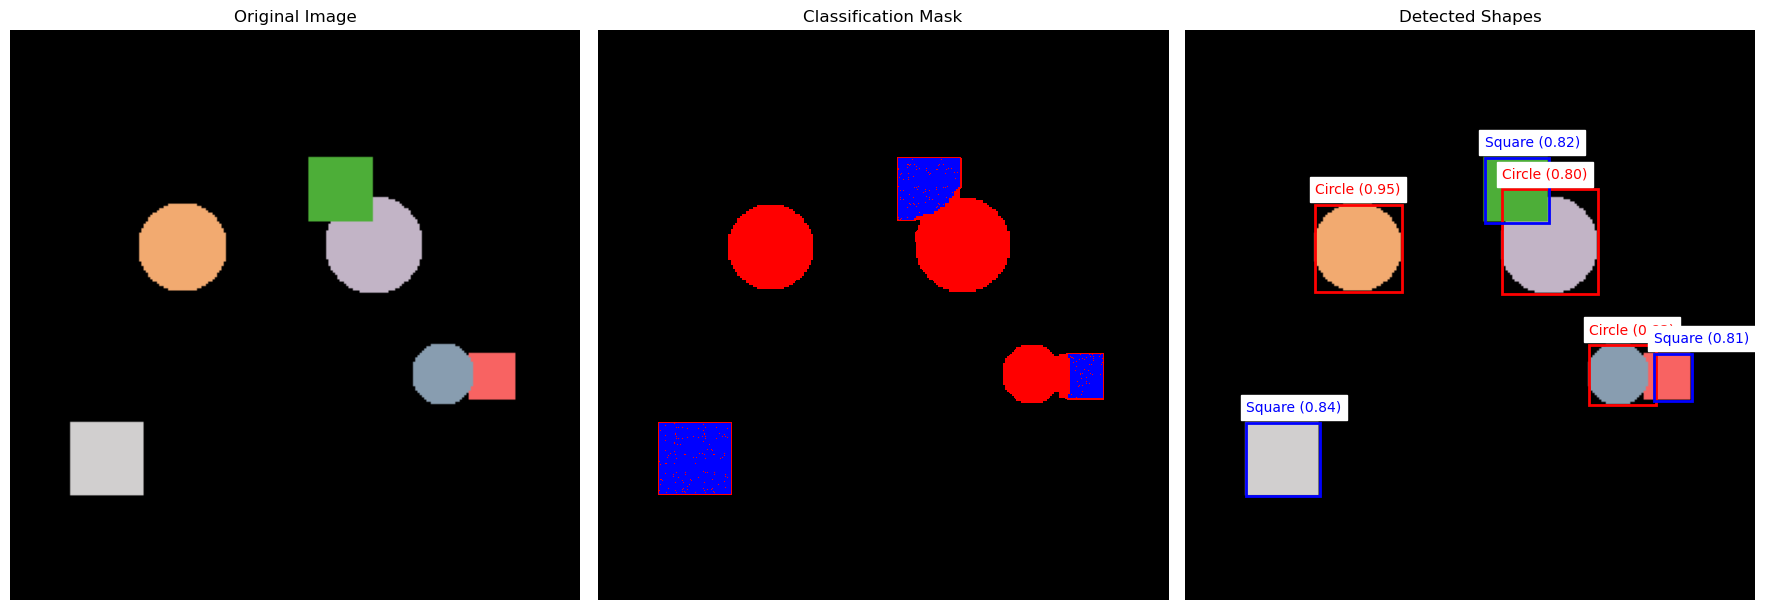

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from skimage import io, transform, measure, morphology, draw


class UNet(nn.Module):
    """
    U-Net architecture for semantic segmentation with multiple classes.
    """
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        """
        Initialize the U-Net model.

        Args:
            in_channels: Number of input image channels (3 for RGB)
            out_channels: Number of output channels (number of classes including background)
                          For shape classification: 3 (background, circles, squares)
            features: List of feature dimensions for each encoder level
        """
        super(UNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder path
        for feature in features:
            self.downs.append(self._double_conv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = self._double_conv(features[-1], features[-1]*2)

        # Decoder path
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(self._double_conv(feature*2, feature))

        # Final convolution outputs class probabilities
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def _double_conv(self, in_channels, out_channels):
        """Create a block with two convolutions and batch normalization."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """Forward pass through the U-Net."""
        skip_connections = []

        # Encoder path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        # Decoder path
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                 mode='bilinear', align_corners=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


class ShapeDataset(Dataset):
    """Dataset for multi-class shape segmentation."""
    def __init__(self, image_dir, mask_dir, transform_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_size = transform_size
        self.images = sorted([f for f in os.listdir(image_dir)
                             if f.endswith(('.png', '.jpg', '.jpeg'))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get file paths
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load with scikit-image
        image = io.imread(img_path)
        mask = io.imread(mask_path, as_gray=True)

        # Ensure image has 3 channels (RGB)
        if len(image.shape) == 2:
            image = np.stack([image, image, image], axis=-1)

        # Resize if needed
        if self.transform_size:
            image = transform.resize(image, self.transform_size,
                                    anti_aliasing=True, preserve_range=True)
            mask = transform.resize(mask, self.transform_size,
                                   order=0, anti_aliasing=False, preserve_range=True)

        # Normalize image to [0, 1]
        if image.max() > 1.0:
            image = image.astype(np.float32) / 255.0

        # Convert mask to class indices (0: background, 1: circle, 2: square)
        if mask.max() > 2.0:  # If mask values are in [0, 255] range
            # Scale to [0, 2] range and round to nearest integer
            mask = np.round(mask * 2 / mask.max()).astype(np.int64)
        else:
            mask = mask.astype(np.int64)

        # Convert to PyTorch tensors
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()
        mask = torch.from_numpy(mask).long()

        return image, mask


def create_shape_dataset(output_dir, num_images=100, image_size=(256, 256)):
    """
    Create a synthetic dataset of images with circles AND squares for shape classification.

    Args:
        output_dir: Directory to save generated images and masks
        num_images: Number of image-mask pairs to generate
        image_size: Size of generated images (height, width)
    """
    # Create output directories
    os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "masks"), exist_ok=True)

    for i in range(num_images):
        # Create empty image and mask
        image = np.zeros((*image_size, 3), dtype=np.uint8)
        mask = np.zeros(image_size, dtype=np.uint8)

        # Add random shapes (circles and squares)
        num_shapes = np.random.randint(3, 8)

        for _ in range(num_shapes):
            # Randomly choose between circle (1) and square (2)
            shape_type = np.random.randint(1, 3)  # 1 = circle, 2 = square

            # Size and position parameters
            size = np.random.randint(20, 50)
            margin = size  # Keep shape away from edges

            center_y = np.random.randint(margin, image_size[0] - margin)
            center_x = np.random.randint(margin, image_size[1] - margin)

            # Random color for image (RGB)
            color = np.random.randint(50, 255, size=3)

            # Draw the shape
            if shape_type == 1:  # Circle
                rr, cc = draw.disk((center_y, center_x), size // 2, shape=image_size)
            else:  # Square
                half_size = size // 2
                start = (center_y - half_size, center_x - half_size)
                extent = (center_y + half_size, center_x + half_size)
                rr, cc = draw.rectangle(start, extent, shape=image_size)

            # Apply to image and mask
            image[rr, cc] = color
            mask[rr, cc] = shape_type  # 1 for circle, 2 for square

        # Save image and mask
        io.imsave(os.path.join(output_dir, "images", f"shape_{i:04d}.png"), image, check_contrast=False)

        # Save mask - scikit-image will scale to [0, 255] for PNG, we'll handle this during loading
        mask_image = mask.astype(np.uint8)
        io.imsave(os.path.join(output_dir, "masks", f"shape_{i:04d}.png"), mask_image, check_contrast=False)

        if (i + 1) % 10 == 0:
            print(f"Generated {i+1}/{num_images} images")


def train_shape_classifier(model, train_loader, val_loader=None, epochs=50, lr=0.001):
    """Train the U-Net model for shape classification."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch_idx, (images, masks) in enumerate(train_loader):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')

        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            correct_pixels = 0
            total_pixels = 0

            with torch.no_grad():
                for images, masks in val_loader:
                    images = images.to(device)
                    masks = masks.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    val_loss += loss.item()

                    # Calculate accuracy
                    preds = torch.argmax(outputs, dim=1)
                    correct_pixels += (preds == masks).sum().item()
                    total_pixels += masks.numel()

            avg_val_loss = val_loss / len(val_loader)
            pixel_accuracy = correct_pixels / total_pixels

            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, Pixel Accuracy: {pixel_accuracy:.4f}')
        else:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}')

    return model


def predict_and_classify_shapes(model, image_path, min_size=50):
    """
    Run inference and classify detected shapes.

    Args:
        model: Trained U-Net model
        image_path: Path to input image
        min_size: Minimum object size to keep (in pixels)

    Returns:
        pred_mask: Classification mask
        objects: List of detected objects with shape classification
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    # Load and preprocess image
    image = io.imread(image_path)
    if len(image.shape) == 2:
        image = np.stack([image, image, image], axis=-1)

    # Save original dimensions
    h, w = image.shape[:2]

    # Resize to model input size
    image_resized = transform.resize(image, (256, 256),
                                    anti_aliasing=True, preserve_range=True)

    # Normalize and convert to tensor
    if image_resized.max() > 1.0:
        image_resized = image_resized.astype(np.float32) / 255.0

    image_tensor = torch.from_numpy(image_resized.transpose(2, 0, 1)).float()
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension

    # Run inference
    with torch.no_grad():
        output = model(image_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Resize back to original dimensions if needed
    if (h, w) != pred_mask.shape:
        pred_mask = transform.resize(pred_mask, (h, w), order=0,
                                    preserve_range=True).astype(np.int64)

    # Post-process to find and classify individual shapes
    objects = []

    # Process each class separately (1: circles, 2: squares)
    for class_id in [1, 2]:
        # Create binary mask for this class
        class_mask = (pred_mask == class_id)

        # Remove small objects
        cleaned_mask = morphology.remove_small_objects(class_mask, min_size=min_size)

        # Label connected components
        labeled_mask = measure.label(cleaned_mask)

        # Get shape name
        shape_name = "Circle" if class_id == 1 else "Square"

        # Extract region properties
        for region in measure.regionprops(labeled_mask):
            # Calculate shape features for validation
            perimeter = region.perimeter
            area = region.area

            # Circularity = 4π × area / perimeter²
            # Perfect circle has circularity of 1.0, square ~0.78
            circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

            objects.append({
                'class_id': class_id,
                'class_name': shape_name,
                'bbox': region.bbox,
                'area': area,
                'centroid': region.centroid,
                'circularity': circularity
            })

    return pred_mask, objects


def visualize_shape_classification(image_path, pred_mask, objects):
    """
    Visualize the shape classification results.

    Args:
        image_path: Path to original image
        pred_mask: Predicted class mask (0: background, 1: circle, 2: square)
        objects: List of detected objects with classification
    """
    # Create custom colormap for the mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    boundaries = [0, 1, 2, 3]
    norm = colors.BoundaryNorm(boundaries, cmap.N)

    # Load original image
    image = io.imread(image_path)

    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Predicted mask
    axes[1].imshow(pred_mask, cmap=cmap, norm=norm)
    axes[1].set_title("Classification Mask")
    axes[1].axis("off")

    # Original image with bounding boxes and labels
    axes[2].imshow(image)

    # Add bounding boxes and labels
    for obj in objects:
        # Get bounding box coordinates
        y1, x1, y2, x2 = obj['bbox']

        # Set color based on class
        color = 'red' if obj['class_id'] == 1 else 'blue'

        # Draw rectangle
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                           fill=False, edgecolor=color, linewidth=2)
        axes[2].add_patch(rect)

        # Add label
        label = f"{obj['class_name']} ({obj['circularity']:.2f})"
        axes[2].text(x1, y1 - 5, label, color=color,
                    fontsize=10, backgroundcolor='white')

    axes[2].set_title("Detected Shapes")
    axes[2].axis("off")

    plt.tight_layout()
    plt.savefig("shape_classification_result.png")
    plt.show()


# Example usage
def main():
    """
    Complete end-to-end example of shape classification using U-Net.
    """
    # 1. Generate synthetic dataset with circles and squares
    print("Generating synthetic dataset...")
    create_shape_dataset("shape_data", num_images=100)

    # 2. Create dataset and data loaders
    dataset = ShapeDataset(
        image_dir="shape_data/images",
        mask_dir="shape_data/masks"
    )

    # Split into train/validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    # 3. Initialize and train model
    # 3 classes: background (0), circle (1), square (2)
    model = UNet(in_channels=3, out_channels=3)

    print("Training model...")
    trained_model = train_shape_classifier(model, train_loader, val_loader, epochs=20)

    # 4. Save the trained model
    torch.save(trained_model.state_dict(), "shape_classifier_model.pth")

    # 5. Run inference on a test image
    print("Running inference...")
    test_image_path = "shape_data/images/shape_0000.png"
    pred_mask, objects = predict_and_classify_shapes(
        trained_model,
        test_image_path
    )

    print(f"Found {len(objects)} shapes")
    for i, obj in enumerate(objects):
        print(f"Shape {i+1}: {obj['class_name']}, "
              f"Area={obj['area']}, Circularity={obj['circularity']:.2f}")

    # 6. Visualize results
    visualize_shape_classification(test_image_path, pred_mask, objects)


if __name__ == "__main__":
    # Set environment variable to avoid OpenMP conflicts
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
    main()

Other tests

In [4]:
def load_model_and_infer(model_path, image_path, min_size=50):
    """
    Load a saved U-Net model and run inference on a new image.

    Args:
        model_path: Path to saved model weights
        image_path: Path to input image
        min_size: Minimum object size to keep (in pixels)

    Returns:
        pred_mask: Classification mask
        objects: List of detected objects with shape classification
    """
    # 1. Initialize the model with same architecture used during training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet(in_channels=3, out_channels=3)  # 3 classes: background, circle, square

    # 2. Load saved weights
    model.load_state_dict(torch.load(model_path, map_location=device))

    # 3. Set model to evaluation mode
    model.eval()
    model = model.to(device)

    print(f"Model loaded from {model_path}")

    # 4. Load and preprocess the image
    image = io.imread(image_path)

    # Handle grayscale images
    if len(image.shape) == 2:
        image = np.stack([image, image, image], axis=-1)

    # Save original dimensions
    h, w = image.shape[:2]

    # Resize to model input size
    image_resized = transform.resize(image, (256, 256),
                                    anti_aliasing=True, preserve_range=True)

    # Normalize to [0, 1]
    if image_resized.max() > 1.0:
        image_resized = image_resized.astype(np.float32) / 255.0

    # Convert to tensor and add batch dimension
    image_tensor = torch.from_numpy(image_resized.transpose(2, 0, 1)).float().unsqueeze(0)
    image_tensor = image_tensor.to(device)

    # 5. Run inference
    with torch.no_grad():
        output = model(image_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # 6. Resize back to original dimensions if needed
    if (h, w) != pred_mask.shape:
        pred_mask = transform.resize(pred_mask, (h, w), order=0,
                                   preserve_range=True).astype(np.int64)

    # 7. Post-process to identify and classify shapes
    objects = []

    # Process each class (1: circles, 2: squares)
    for class_id in [1, 2]:
        class_mask = (pred_mask == class_id)
        cleaned_mask = morphology.remove_small_objects(class_mask, min_size=min_size)
        labeled_mask = measure.label(cleaned_mask)

        shape_name = "Circle" if class_id == 1 else "Square"

        for region in measure.regionprops(labeled_mask):
            perimeter = region.perimeter
            area = region.area

            # Circularity = 4π × area / perimeter²
            circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

            objects.append({
                'class_id': class_id,
                'class_name': shape_name,
                'bbox': region.bbox,
                'area': area,
                'centroid': region.centroid,
                'circularity': circularity
            })

    return pred_mask, objects

Model loaded from shape_classifier_model.pth
Found 6 shapes
Shape 1: Circle, Area=1649.0, Circularity=0.95
Shape 2: Circle, Area=1649.0, Circularity=0.95
Shape 3: Circle, Area=2809.0, Circularity=0.93
Shape 4: Circle, Area=437.0, Circularity=1.00
Shape 5: Circle, Area=2374.0, Circularity=0.22
Shape 6: Square, Area=1812.0, Circularity=0.82


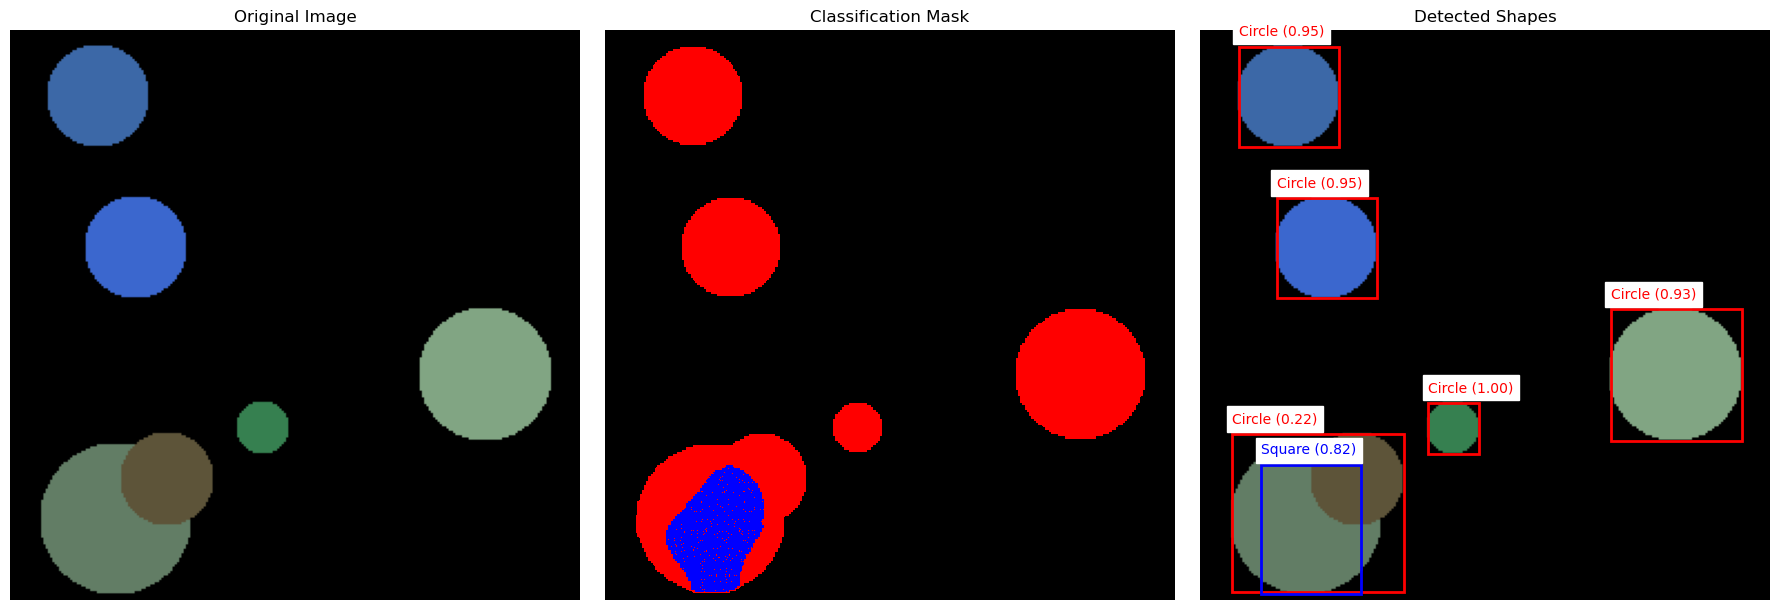

In [9]:
test_image_path = "synthetic_data\images\circle_0015.png"
pred_mask, objects = load_model_and_infer(model_path="shape_classifier_model.pth", image_path=test_image_path)

print(f"Found {len(objects)} shapes")
for i, obj in enumerate(objects):
    print(f"Shape {i+1}: {obj['class_name']}, "
            f"Area={obj['area']}, Circularity={obj['circularity']:.2f}")

# 6. Visualize results
visualize_shape_classification(test_image_path, pred_mask, objects)